# Gradient-based multislice ptychography with Jax and the WPM

The goal of this notebook is to demonstrate ptychography with the wide angle wave propagation method. 

In [1]:
%matplotlib inline

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import abtem
import ase
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
from itertools import chain, cycle, repeat

from pathlib import Path
import sys
# add parent folder (and common src folder) to sys.path so imports can be resolved
parent = Path.cwd().parent
candidates = [parent, parent / "src"]
for p in candidates:
    if p.exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))


import tqdm.auto as tqdm
from tqdm import trange
from abtem.multislice import FresnelPropagator as Propagator
from jax_multislice import get_abtem_transmit, Propagator as convolve2d, shift_kernel, energy2wavelength, energy2sigma, get_frequencies, simple_fwhm, electron_refractive_index

abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})

jax.config.update("jax_enable_x64", True)


## Simulate data with abTEM

To make this notebook standalone, we will simulate our dataset here with abTEM. For speed this will only be quite a small-scale dataset.

### Structure + Potential

First build a structure to simulate and reconstruct. I stretch the `MoS2` unit cell slightly in the z-direction to give more propagation between the slices:

In [2]:
atoms = ase.build.mx2(vacuum=0.8)
atoms.set_cell(atoms.cell * np.asarray([1, 1, 4]), scale_atoms=True)
atoms = abtem.orthogonalize_cell(atoms)
atoms *= (3, 2, 1)  # this sets our horizontal extent, and by consequence our final diffraction pattern size

Choose a slice thickness to acheive one slice-per-layer:

In [3]:
base_sampling = 0.2
base_slice_thickness = 7

potential = abtem.Potential(
    atoms,
    sampling=base_sampling,
    slice_thickness=base_slice_thickness,
)
print(potential.shape)

(3, 48, 56)


As you can see the potential grid is quite small to allow this to run quickly in a notebook.

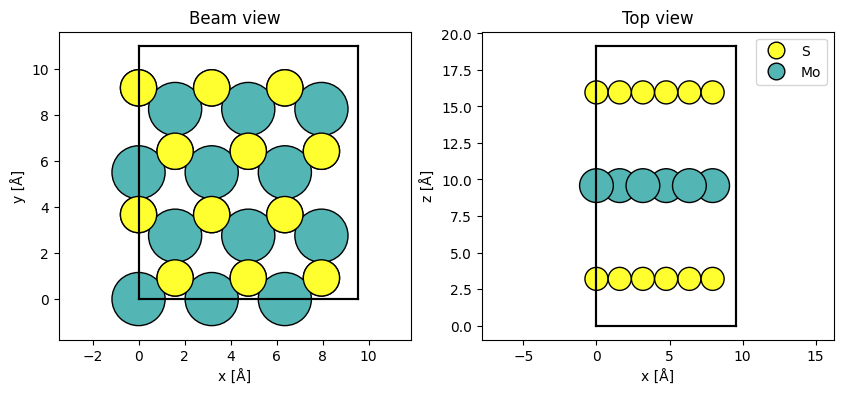

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True);

We also compute the complex transmission function for the potential, this will be used to compare the reconstruction to the simulation:

In [5]:
energy = 200e3
transmit = get_abtem_transmit(potential, energy)

Visualise the different slices of the potential:

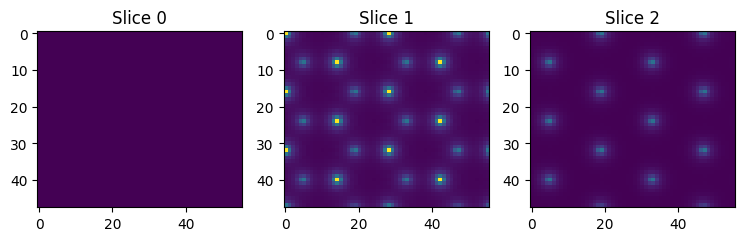

In [6]:
potential_array = potential.build(lazy=False).array
rows = int(np.floor(np.sqrt(len(potential_array))))
cols = int(np.ceil(np.sqrt(len(potential_array))))
if rows * cols < len(potential_array):
    cols += 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
vmin = potential_array.min()
vmax = potential_array.max()
for i, (p, s_ax) in enumerate(zip(potential_array, ax.ravel())):
    s_ax.imshow(p, vmin=vmin, vmax=vmax)
    s_ax.set_title(f"Slice {i}")

### Probe

We generate a probe with some strong aberrations, including the all-important defocus:

In [7]:
wavelength = energy2wavelength(energy)
semiangle_cutoff = 40.
defocus = 40.
astigmatism = 0.
astigmatism_angle = 0.
Cs = 1e2
coma = 5e2
coma_angle = 0.
trefoil = 1e2
trefoil_angle = np.pi / 7

W1212 11:18:21.122379 2174749 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1212 11:18:21.129234 2174342 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [8]:
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    Cs=Cs,
    astigmatism=astigmatism,
    astigmatism_angle=astigmatism_angle,
    trefoil=trefoil,
    trefoil_angle=trefoil_angle,
    coma=coma,
    coma_angle=coma_angle,
)
probe.grid.match(potential)
probe.shape

(48, 56)

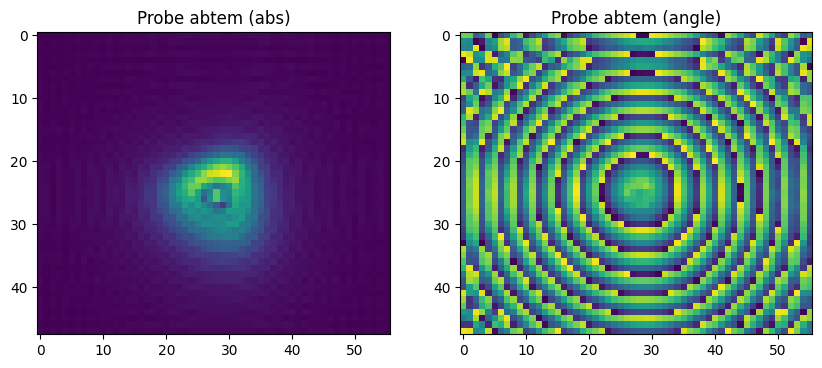

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(np.abs(probe.build(lazy=False).array))
ax1.set_title('Probe abtem (abs)');
ax2.imshow(np.angle(probe.build(lazy=False).array))
ax2.set_title('Probe abtem (angle)');

### Scan grid

As the potential is periodic we can have a scan grid that covers the whole object.

In principle as the probe is so defocused we could have a very large scan step as we have a lot of overlap in real-space.

In [10]:
grid_scan = abtem.GridScan(
    end=(1, 1),
    fractional=True,
    sampling=probe.aperture.nyquist_sampling * 3,
    potential=potential,
)
scan_positions = np.array(grid_scan.get_positions())
grid_scan.shape

(21, 24)

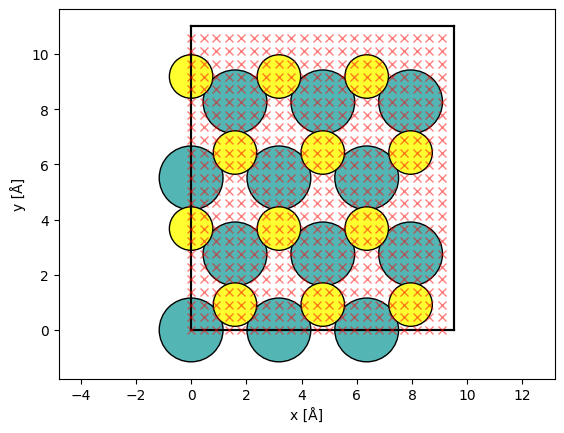

In [11]:
fig, ax = abtem.show_atoms(atoms)
scan_pos_flat = scan_positions.reshape(-1, 2)
ax.plot(scan_pos_flat[:, 0], scan_pos_flat[:, 1], 'rx', alpha=0.5);

We can estimate the overlap of adjacent probe positions in real space:

In [12]:
scan_step = (scan_pos_flat[1] - scan_pos_flat[0]).max()
probe_fwhm = simple_fwhm(np.abs(probe.build(lazy=False).array)[probe.gpts[0] // 2, :]) * probe.sampling[0]
print(f"Scan step of {scan_step:.1f} Å, probe FWHM of {probe_fwhm:.1f} Å, ratio {probe_fwhm / scan_step:.2f}")

Scan step of 0.5 Å, probe FWHM of 2.4 Å, ratio 5.20


Pre-generate all the probes for later use in iteration:

In [13]:
all_probes = probe.build(scan=grid_scan, lazy=False).array
all_probes_flat = all_probes.reshape(-1, *all_probes.shape[-2:])
all_probes_flat.dtype

dtype('complex128')

### Generate diffraction patterns

In [14]:
detector = abtem.PixelatedDetector(max_angle='full')
measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=detector,
)
abtem_patterns = measurements.compute().array
abtem_patterns_flat = abtem_patterns.reshape(-1, *abtem_patterns.shape[-2:])
abtem_patterns.shape

[########################################] | 100% Completed | 204.79 ms


(21, 24, 48, 56)

## Building a forward multislice model

One aspect of gradient-based multislice is that the reconstruction algorithm is "free", which is to say we just need to build a differentiable forward multislice model, and the implementation is capable of reversing it.

Forward multislice alternates between:

- Interaction: the probe or wavefront is multiplied with the object slice
- Propagation: the wavefront is convolved with a Fresnel propagation kernel for the inter-slice distance

Finally, the diffraction pattern is created from the FFT of the final wavefront, and its amplitude squared, i.e. the *intensity* we would see experimentally.

In [15]:
from jax_multislice import wpm_step_adaptive


def simulate_pattern(object, probe, dz, energy, ps):
    wavefront = probe
    wavefronts = []
    for i in trange(object.shape[0], desc="WPM slices"):
        potential = jnp.angle(object[i]) / energy2sigma(energy)
        n = electron_refractive_index(potential, energy)
        wavefront, _, _, _ = wpm_step_adaptive(wavefront, n, dz, energy, ps, n_bins=512, power_spacing=2.0)
        wavefronts.append(wavefront)
    
    exit_wave = wavefront
    
    detector_wavefront = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(detector_wavefront.real)
        + jnp.square(detector_wavefront.imag)
    )
    return exit_wave, diffraction_pattern

simulate_pattern_jit = jax.jit(simulate_pattern)
simulate_pattern_vmap = jax.vmap(simulate_pattern_jit, in_axes=(None, 0, None, None, None))

We can check our own forward multislice model on abTEM's model at a given scan grid position, as you an see they are equivalent to numerical error:

WPM slices:   0%|          | 0/3 [00:00<?, ?it/s]

WPM slices: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


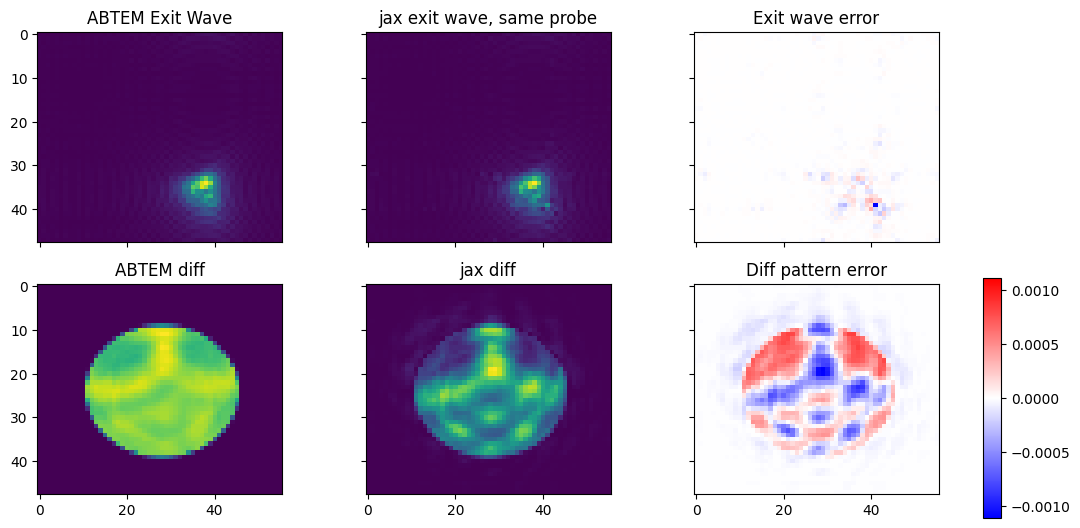

In [16]:
assert np.unique(potential.slice_thickness).size == 1
slice_thickness = potential.slice_thickness[0]

gx, gy = scan_positions.shape[:2]
idx_x, idx_y = 3 * gx // 4, 2 * gy  // 3
plot_scan = abtem.CustomScan(scan_positions[idx_x, idx_y], squeeze=True)

plot_exit_wave = probe.multislice(
    potential,
    scan=plot_scan,
    detectors=abtem.WavesDetector(),
    lazy=False,
).array
plot_probe = probe.build(scan=plot_scan).compute(progress_bar=False).array.squeeze()
assert (plot_probe == all_probes[idx_x, idx_y]).all()

probe_waves = probe._build_waves(probe)
jax_exit_wave, jax_pattern = simulate_pattern(
    transmit,
    all_probes[idx_x, idx_y],
    slice_thickness,
    energy,
    probe.sampling,
)

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
ax = ax.ravel()
ax[0].imshow(np.abs(plot_exit_wave))
ax[0].set_title('ABTEM Exit Wave')
ax[1].imshow(np.abs(jax_exit_wave))
ax[1].set_title('jax exit wave, same probe')
exit_fn_diff = np.abs(plot_exit_wave) - np.abs(jax_exit_wave)
vmax = np.abs(exit_fn_diff).max()
ax[2].imshow(exit_fn_diff, cmap='bwr', vmax=vmax, vmin=-vmax)
ax[2].set_title('Exit wave error');

ax[3].imshow(abtem_patterns[idx_x, idx_y])
ax[3].set_title('ABTEM diff')
ax[4].imshow(jax_pattern)
ax[4].set_title('jax diff');
pattern_diff = abtem_patterns[idx_x, idx_y] - jax_pattern
vmax = np.abs(pattern_diff).max()
im = ax[5].imshow(pattern_diff, cmap='bwr', vmax=vmax, vmin=-vmax)
ax[5].set_title('Diff pattern error');
cbar_ax = fig.add_axes([0.925, 0.07, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax);

## Inverse Multislice, object-optimisation only

To fit an object function to the set of diffraction patterns, we define an error function (*loss* in ML-parlance). The absolute simplest form of this loss the mean-squared-error between the measured and reconstructed diffraction patterns.

Optax provides us this loss as a function `optax.l2_loss(predictions, targets)`.

The reconstruction process is to generate a set of `jax_patterns` with the current `object`, compute a scalar error, then use the gradient of this `loss` with respect to the `object` to do gradient descent, so modifying the `object` each iteration.

In [17]:
def loss(target_patterns, object, probes, dz, energy, ps):
    # Simulate the diffraction patterns for a set of probes on the current object estimate
    _, jax_patterns = simulate_pattern_vmap(object, probes, dz, energy, ps)
    return (
        optax.l2_loss(jax_patterns, target_patterns).mean()
    )

loss_jit = jax.jit(loss)

To reconstruct an object we need to choose our number of slices, create an inital guess and generate the other inputs to the forward model, notably all of the probes, and the Fresnel propagator.

In [18]:
num_slices_recon = 3
recon_obj_shape = (num_slices_recon, *transmit.shape[-2:])
opt_object = jnp.ones(recon_obj_shape, dtype=jnp.complex64)

# All the probes as a Jax array
all_probes_flat = jnp.asarray(all_probes_flat)

# Use the abTEM propagator, needs to match the slice thickness in the reconstruction
recon_slice_thickness = float(sum(potential.slice_thickness) / num_slices_recon)
prop_abtem = jnp.asarray(Propagator().get_array(probe_waves, recon_slice_thickness))

We can choose to optimise against abTEM's diffraction patterns or patterns generated with the forward model, as shown above these are equivalent:

In [19]:
transmit = jnp.asarray(transmit)
_, jax_patterns_flat = simulate_pattern_vmap(transmit, all_probes_flat, slice_thickness, energy, probe.sampling)
target_patterns = jax_patterns_flat
target_name = 'abtem'

WPM slices:   0%|          | 0/3 [00:00<?, ?it/s]

WPM slices: 100%|██████████| 3/3 [00:00<00:00, 82.19it/s]


Initialize the optimiser. Contrary to typical use of ADAM this problem can accept a very high initial learning rate.

This optimizer keeps track of the gradients of `loss/object`, so as to choose an appropriate step size when modifying `object`.

In [20]:
learning_rate = 5e1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_object)

The optimisation is run using randomised batches of diffraction patterns (`chunksize` patterns at a time), for a total of `num_epochs` passes over the whole dataset.

In [21]:
num_epochs = 200  # number of passes through the dataset
chunksize = 256  # number of patterns used to compute an update step

Most of the code here is to do with plotting and randomising the sets of patterns we pass to the forward model. In reality it can be summarised as:

```python
for true_patterns in dataset:
    gradient = loss_gradient(true_patterns, object, probe, propagator)
    obj = obj - stepsize * gradient
```

In [ ]:
num_patterns = len(target_patterns)
iteration_idxs = np.arange(num_patterns)
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)
chunks = chunks[:-1]  # skip the last chunk as it may be incomplete, which will add a periodic spike in the loss, not an issue as we are shuffling
assert len(chunks) > 0, "Chunksize is too large for this dataset"

num_iterations = len(chunks) * num_epochs
losses = np.full((num_iterations,), np.nan)

val_grad_fn = jax.value_and_grad(loss_jit, argnums=1)

iteration = 0
for epoch in (outer_pbar := tqdm.trange(num_epochs)):
    np.random.shuffle(iteration_idxs)
    for chunk in chunks:
        loss_val, grads = val_grad_fn(
            target_patterns[iteration_idxs[chunk]],
            opt_object,
            all_probes_flat[iteration_idxs[chunk]],
            recon_slice_thickness,
            energy,
            probe.sampling,
        )
        # Conjugating the gradients is necessary in Jax, we are not sure why
        grads = jnp.conjugate(grads)
        updates, opt_state = optimizer.update(grads, opt_state)
        opt_object = optax.apply_updates(opt_object, updates)
        losses[iteration] = loss_val
        iteration += 1
    if (epoch % 1) == 0:
        outer_pbar.set_description(f"Loss {losses[max(0, iteration - 20):iteration].mean(): .3e}")

    if loss_val < 1e-14:
        print(f"Converged at epoch {epoch} with loss {loss_val:.3e}")
        break
    

  0%|          | 0/200 [00:00<?, ?it/s]

WPM slices: 100%|██████████| 3/3 [00:00<00:00, 37.24it/s]


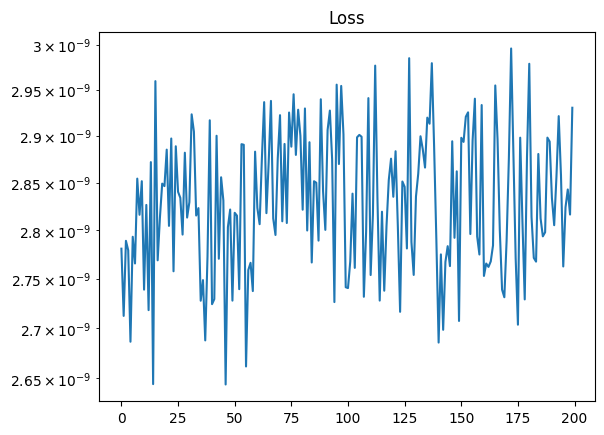

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("Loss")
ax.set_yscale("log")

Once done, we can compare the reconstructed object to the abTEM object used to generate the patterns:

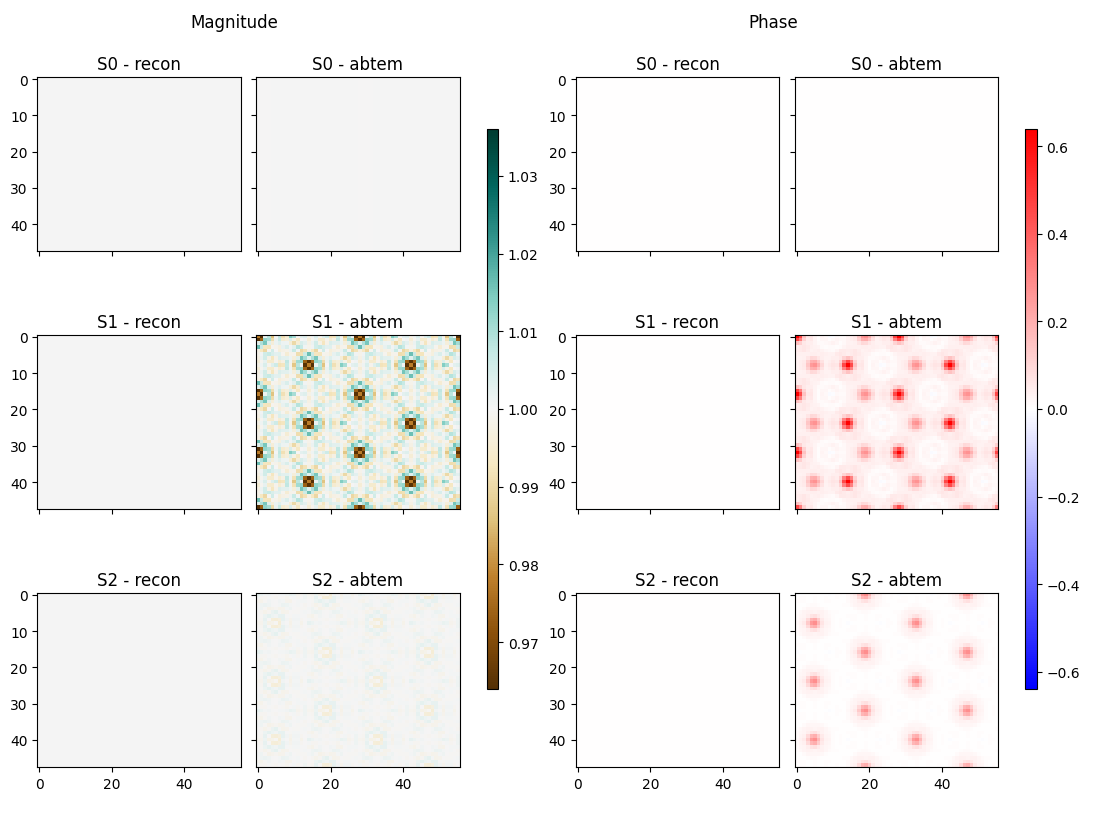

In [ ]:
fig = plt.figure(layout="constrained", figsize=(11, 8))
subfigs = fig.subfigures(1, 3, wspace=0.22, width_ratios=[1, 1, 0.05])

axs = subfigs[0].subplots(num_slices_recon, 2, sharex=True, sharey=True)
a_max = max(np.abs((np.abs(opt_object) - 1)).max(), np.abs((np.abs(transmit) - 1)).max())
ang_max = max(np.abs(np.angle(opt_object)).max(), np.abs(np.angle(transmit)).max())


for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_object, transmit, axs)):
    im_abs = ax1.imshow(np.abs(recon_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.abs(abtem_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax2.set_title(f"S{i} - {target_name}")
subfigs[0].suptitle("Magnitude")
cbar_ax = subfigs[0].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[0].colorbar(im_abs, cax=cbar_ax)

num_slices_potential = transmit.shape[0]
axs = subfigs[1].subplots(num_slices_potential, 2, sharex=True, sharey=True)
for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_object, transmit, axs)):
    im_ang = ax1.imshow(np.angle(recon_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.angle(abtem_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax2.set_title(f"S{i} - {target_name}")
subfigs[1].suptitle("Phase");
cbar_ax = subfigs[1].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[1].colorbar(im_ang, cax=cbar_ax);